In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_optimal_Tp_map(ds_sat, df_pre, E, tau, Tp_list:list=[0,-1,-2,-3,-4,-6,-8,-10,-15,-20], 
                          libSizes="10 20 30 40 50 60 70", show_figures=True):
    """
    Loop over all grid points and for each, test Tp values from Tp_min to Tp_max.
    For each grid point, the Tp value that yields the highest CCM skill (Y:X) is stored.
    A global map is then plotted to show the optimal Tp for each grid point.

    Parameters:
        ds_sat      : xarray.Dataset
                      Dataset with mean SAT data (requires variables "sat", "lat", "lon", "age").
        df_pre      : pandas.DataFrame
                      DataFrame with column "pre" and an "age" coordinate.
        E           : int
                      Embedding dimension.
        tau         : int
                      Time delay.
        Tp_min      : int, optional
                      Minimum Tp value to test (default is 1).
        Tp_max      : int, optional
                      Maximum Tp value to test (default is 10).
        libSizes    : str, optional
                      Library sizes for CCM (default is "10 20 30 40 50 60 70").
        show_figures: bool, optional
                      If True, plot the global map (default is True).

    Returns:
        optimum_Tp_map : 2D numpy array (shape: [nlat, nlon]) containing the optimal Tp at each grid point.
    """
    nlat = ds_sat.sizes["lat"]
    nlon = ds_sat.sizes["lon"]
    ages = ds_sat["age"].values
    optimum_Tp_map = np.full((nlat, nlon), np.nan)
    
    # Loop over grid points
    for iLat in range(nlat):
        for iLon in range(nlon):
            # Extract the local SAT time series for this grid point
            sat_ts = ds_sat["sat"].isel(lat=iLat, lon=iLon).values
            # Build temporary DataFrame for CCM (predicting pre from SAT)
            temp_df = pd.DataFrame({
                "Time": ages*-1,
                "X": df_pre["pre"],  # pre series to be predicted
                "Y": sat_ts          # SAT (predictor)
            })
            
            best_rho = -np.inf
            best_Tp = np.nan
            # Loop over Tp values 
            for Tp in Tp_list:
                ccm_out = CCM(
                    dataFrame   = temp_df,
                    E           = E,
                    tau         = tau,
                    columns     = "Y",   # using SAT to build the manifold
                    target      = "X",   # predicting pre
                    libSizes    = libSizes,
                    sample      = 10,
                    random      = True,
                    replacement = False,
                    Tp          = Tp
                )
                # Use the CCM skill at the largest library size
                largest_L = ccm_out["LibSize"].max()
                mask_last = ccm_out["LibSize"] == largest_L
                rho_at_largest = ccm_out.loc[mask_last, "Y:X"].mean()
                
                if rho_at_largest > best_rho:
                    best_rho = rho_at_largest
                    best_Tp = Tp
            
            optimum_Tp_map[iLat, iLon] = best_Tp
            print(f"Grid point (lat idx {iLat}, lon idx {iLon}): Optimal Tp = {best_Tp}, CCM rho = {best_rho}")
    
    # Plot global map of optimal Tp values
    if show_figures:
        lats = ds_sat["lat"].values
        lons = ds_sat["lon"].values
        lon_grid, lat_grid = np.meshgrid(lons, lats)
    
        fig = plt.figure(figsize=(11, 6))
        ax = plt.axes(projection=ccrs.Robinson())
        ax.coastlines()
        # Using "plasma" colormap to represent different Tp values
        pcm = ax.pcolormesh(lon_grid, lat_grid, optimum_Tp_map,
                            transform=ccrs.PlateCarree(), shading="auto", cmap="plasma")
        cb = plt.colorbar(pcm, orientation="horizontal", pad=0.07, shrink=0.8)
        cb.set_label("Optimal Tp (Prediction Horizon)")
        ax.set_title("Global Map of Optimal Tp for Highest CCM Skill")
        plt.show()
    
    return optimum_Tp_map

# Example usage:
# optimum_Tp = plot_optimal_Tp_map(ds_sat=ds_sat, df_pre=df_pre, E=4, tau=3, Tp_min=1, Tp_max=10)


xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}Grid point (lat idx 0, lon idx 0): Optimal Tp = -8, CCM rho = 0.9823093017036182
Grid point (lat idx 0, lon idx 1): Optimal Tp = -8, CCM rho = 0.984516617819048
Grid point (lat idx 0, lon idx 2): Optima

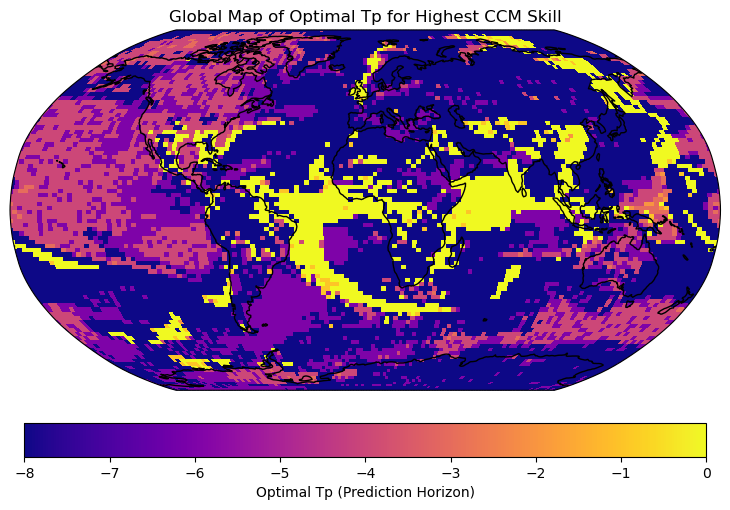

In [8]:

import xarray as xr
import pandas as pd


ds_sat = xr.open_dataset('LGMR_data/ds_sat_flipped.nc')
ds_sat.info()

df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")


optimum_Tp = plot_optimal_Tp_map(ds_sat=ds_sat, df_pre=df_pre, E=4, tau=3, Tp_list=[0,-1,-2,-3,-4,-6,-8])

# Obl

xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}Grid point (lat idx 0, lon idx 0): Optimal Tp = -3, CCM rho = 0.9975438320495176
Grid point (lat idx 0, lon idx 1): Optimal Tp = -3, CCM rho = 0.9975938276467649
Grid point (lat idx 0, lon idx 2): Optim

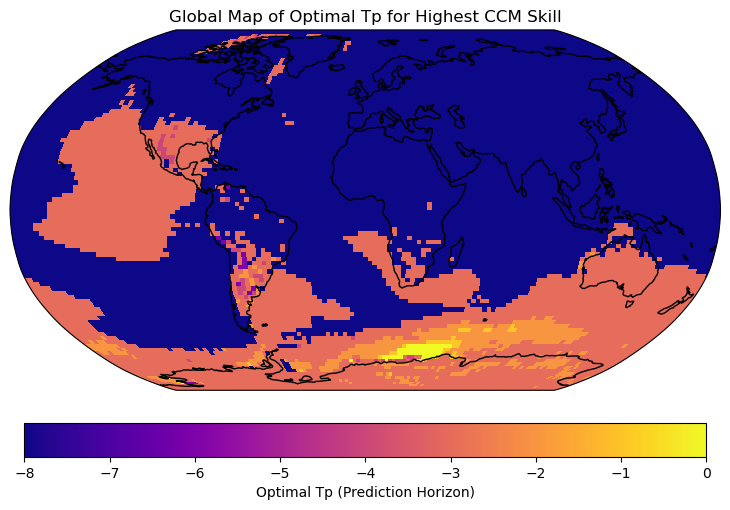

In [7]:

import xarray as xr
import pandas as pd


ds_sat = xr.open_dataset('LGMR_data/ds_sat_flipped.nc')
ds_sat.info()

df_obl = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\obl.csv")
# rename columns
df_obl.columns = ["age", "pre"]


optimum_Tp = plot_optimal_Tp_map(ds_sat=ds_sat, df_pre=df_obl, E=4, tau=8, Tp_list=[0,-1,-2,-3,-4,-6,-8],libSizes="10 20 30 40 50 60")

# Tp from 1 to 10

In [4]:
# save the optimal Tp map using pickle to the output/
import pickle
with open("output/optimum_Tp_map.pkl", "wb") as f:
    pickle.dump(optimum_Tp, f)

In [5]:
# load the optimal Tp map using pickle
import pickle
with open("output/optimum_Tp_map.pkl", "rb") as f:
    optimum_Tp = pickle.load(f)

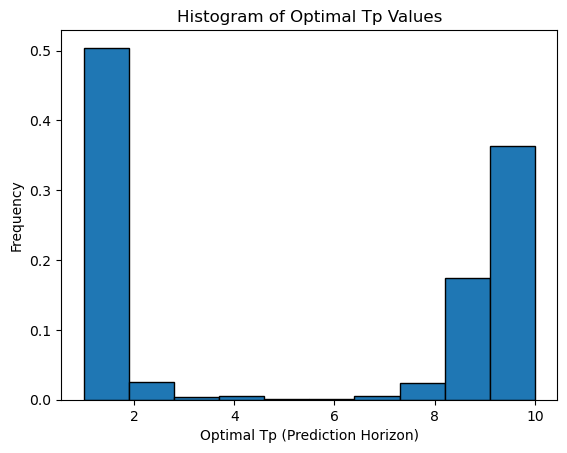

In [ ]:
# reshape the optimal Tp map to 1D array and plot the histogram
optimum_Tp_1D = optimum_Tp.flatten()
plt.hist(optimum_Tp_1D, bins=10, density=True, edgecolor="black")
plt.xlabel("Optimal Tp (Prediction Horizon)")
plt.ylabel("Frequency")
plt.title("Histogram of Optimal Tp Values")
plt.show()